In [ ]:
import autorootcwd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import json
import pandas as pd
import clip
import matplotlib.pyplot as plt
import numpy as np

class ImageTextDataset(Dataset):
    def __init__(self, images_folder, annotations_path, tokenize, max_captions=4, transform=None):
        self.images_folder = images_folder
        self.annotations_df = self.load_annotations(annotations_path, max_captions)
        self.transform = transform
        self.tokenize = tokenize

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        img_name, captions = self.annotations_df.iloc[idx]
        img_path = os.path.join(self.images_folder, f"{img_name:012d}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        annotation = self.tokenize(captions[0])

        return image, annotation

    def load_annotations(self, annotations_path, max_captions):
        with open(annotations_path, 'r') as f:
            annotations_data = json.load(f)

        # Flatten the nested structure and select relevant columns
        annotations_df = pd.json_normalize(annotations_data['annotations'], sep='_')[['image_id', 'caption']]

        # Combine multiple captions for the same image
        annotations_df = annotations_df.groupby('image_id')['caption'].apply(list).reset_index(name='captions')

        # Limit the number of captions per image
        annotations_df['captions'] = annotations_df['captions'].apply(lambda x: x[:max_captions])

        return annotations_df

# Custom collate function to handle non-tensor data types
def custom_collate(batch):
    images, captions = zip(*batch)
    images = torch.stack([transforms.ToTensor()(img) for img in images])
    return images, captions

# Resize and crop the images to 256x256
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((256, 256)),
])

# Example usage:
# Specify the paths to your image folders and annotation JSON file
train_images_path = "data/coco2017/train2017"
val_images_path = "data/coco2017/val2017"
captions_train_path = "data/coco2017/annotations/captions_train2017.json"
captions_val_path = "data/coco2017/annotations/captions_val2017.json"  # Update this line

# Instantiate the dataset with the CLIP tokenizer and image transform
train_dataset = ImageTextDataset(images_folder=train_images_path, annotations_path=captions_train_path, max_captions=4, transform=image_transform, tokenize=clip.tokenize)
val_dataset = ImageTextDataset(images_folder=val_images_path, annotations_path=captions_val_path, max_captions=4, transform=image_transform, tokenize=clip.tokenize)

# Example usage of DataLoader with custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)

/home/kanghyun/clip-from-scratch/.venv/lib/python3.12/site-packages/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging


In [2]:
# Dataset 실험해보기

# 1. 데이터셋 크기 확인
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

# 2. 첫 번째 샘플 확인
sample_image, sample_caption = train_dataset[0]
print(f"\nSample image shape: {sample_image.size}")
print(f"Sample caption: {sample_caption}")

# 3. 여러 샘플들 확인
print("\n=== 처음 5개 샘플들의 캡션 ===")
for i in range(5):
    img, cap = train_dataset[i]
    print(f"Index {i}: {cap}")

# 4. annotations 데이터프레임 구조 확인
print(f"\nAnnotations DataFrame shape: {train_dataset.annotations_df.shape}")
print("First few rows:")
print(train_dataset.annotations_df.head())

# 5. 이미지 변환 테스트
print(f"\nOriginal image type: {type(sample_image)}")
if hasattr(sample_image, 'size'):
    print(f"Image size: {sample_image.size}")

# 6. DataLoader 테스트
print("\n=== DataLoader 테스트 ===")
batch_iter = iter(train_dataloader)
batch_images, batch_captions = next(batch_iter)
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch captions length: {len(batch_captions)}")
print(f"First caption in batch: {batch_captions[0]}")

Train dataset size: 118287
Val dataset size: 5000

Sample image shape: (256, 256)
Sample caption: tensor([[49406, 35439,   539, 26934,   539,  1559,   682,  5942, 19094,   537,
          5066,   269, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

=== 처음 5개 샘플들의 캡션 ===
Index 0: tensor([[49406, 35439,   539, 26934,   539,  1559,   682,  5942, 19094,   537,
          5066,   269, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
 

In [4]:
# 1. 다양한 batch size로 테스트
print("=== 다양한 batch size 테스트 ===")
for batch_size in [1, 4, 8]:
    temp_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
    batch = next(iter(temp_loader))
    print(f"Batch size {batch_size}: images shape {batch[0].shape}, captions length {len(batch[1])}")

# 2. 토크나이즈된 텍스트 분석
print("\n=== 토크나이즈된 텍스트 분석 ===")
sample_tokenized = train_dataset[0][1]
print(f"Tokenized shape: {sample_tokenized.shape}")
print(f"Tokenized values: {sample_tokenized[:20]}...")  # 처음 20개 토큰만

# 3. 이미지 변환 전후 비교
print("\n=== 이미지 변환 전후 비교 ===")
# 변환 없는 dataset 생성
no_transform_dataset = ImageTextDataset(
    images_folder=train_images_path, 
    annotations_path=captions_train_path, 
    max_captions=4, 
    transform=None, 
    tokenize=clip.tokenize
)

original_img, _ = no_transform_dataset[0]
transformed_img, _ = train_dataset[0]

print(f"Original image size: {original_img.size}")
print(f"Transformed image size: {transformed_img.size}")

=== 다양한 batch size 테스트 ===
Batch size 1: images shape torch.Size([1, 3, 256, 256]), captions length 1
Batch size 4: images shape torch.Size([4, 3, 256, 256]), captions length 4
Batch size 8: images shape torch.Size([8, 3, 256, 256]), captions length 8

=== 토크나이즈된 텍스트 분석 ===
Tokenized shape: torch.Size([1, 77])
Tokenized values: tensor([[49406, 35439,   539, 26934,   539,  1559,   682,  5942, 19094,   537,
          5066,   269, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)...

=== 이미지 변환 전후 비교 ===
Original imag

tensor([49406, 35439,   539, 26934,   539,  1559,   682,  5942, 19094,   537,
         5066,   269, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], dtype=torch.int32)
<|startoftext|>closeup of bins of food that include broccoli and bread . <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


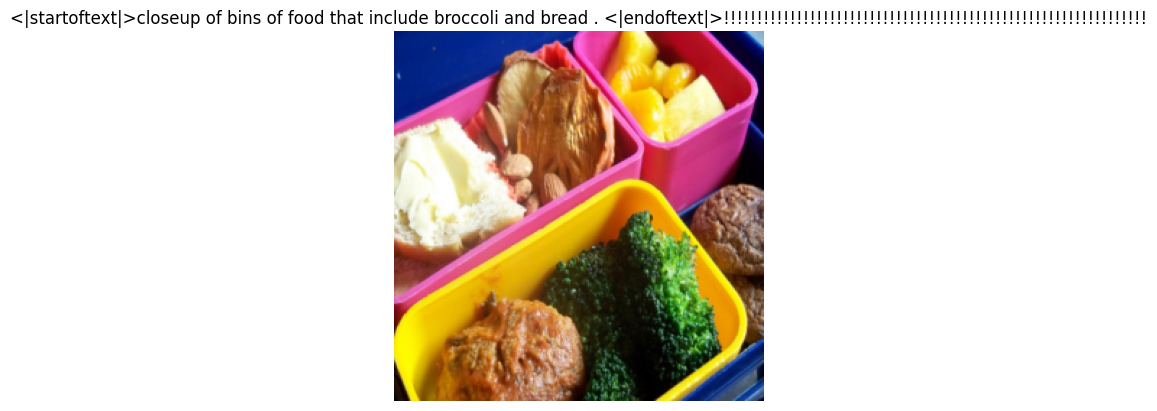

In [16]:
# CLIP의 SimpleTokenizer를 사용해서 토큰을 다시 텍스트로 변환
tokenizer = clip.simple_tokenizer.SimpleTokenizer()
def decode_captions(token_ids):
    captions = tokenizer.decode(token_ids)
    return "".join(captions)

# sample_image, sample_caption에 대해서 확인 
print(sample_caption[0]) # 첫번째 배치 
sample_caption_decode = decode_captions(sample_caption[0].tolist()) # 다시 언어로 decode
print(sample_caption_decode) # 바뀐 언어 

plt.imshow(sample_image)
plt.axis('off')
plt.title(sample_caption_decode)
plt.show()
